## calculate climatological flux correction

In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

Text(0.5, 1.0, 'global avg mean wfo diff, monthly \n (yearly mean v small: 2.3778268618516067e-08 kg/m2/s)')

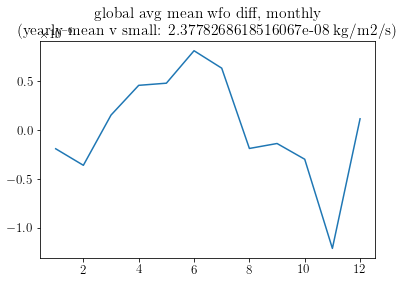

In [2]:
view = True
if view:

    tvar = 'wfo'
    KDD0 = xr.open_dataset(f'./data/KDD0_{tvar}.nc')
    KWD0 = xr.open_dataset(f'./data/KWD0_{tvar}.nc')


    KDD0['time_counter'] = KDD0.indexes['time_counter'].to_datetimeindex()
    KWD0['time_counter'] = KWD0.indexes['time_counter'].to_datetimeindex()

    KWD0_clim = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).mean("time_counter")
    KDD0_clim = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).mean("time_counter")
    
  
tmask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/mesh_mask3_6.nc')

KWD = KWD0_clim.weighted(tmask.csize).mean(dim = ['y','x'])
KDD = KDD0_clim.weighted(tmask.csize).mean(dim = ['y','x'])


# print('climatological global empave diff is small')
# print(KDD.wfo.values-KWD.wfo.values)

KWD0_40y = KWD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")
KDD0_40y = KDD0.sel(time_counter=slice(f'{1980}-01-01', f'{2019}-12-31')).groupby("time_counter.month").mean("time_counter")

diff_D = KDD0_40y - KWD0_40y

mean_ts = diff_D.weighted(tmask.csize).mean(dim = ['y','x'])

plt.plot(np.arange(1,13), mean_ts.wfo.values)
plt.title('global avg mean wfo diff, monthly \n (yearly mean v small: 2.3778268618516067e-08 kg/m2/s)')

## map of summer and winter EMPave

## create daily adjustments (at monthly resolution, nothing fancy)

In [3]:

diff_D = diff_D.rename({"month": "time"})
diff_clim = diff_D.wfo.values
print(np.shape(diff_clim))

#days of year
nlys = np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335,365])
lys = np.array([1, 32, 61, 92, 122, 153, 183, 214, 245, 275, 306, 336,366])

lydiff = np.zeros([366,149,182])
nlydiff = np.zeros([365,149,182])

#corrector
for i in range(0,12):
    
    lydiff[lys[i]:lys[i+1],:,:] = diff_clim[i,:,:]
    nlydiff[nlys[i]:nlys[i+1],:,:] = diff_clim[i,:,:]
    

(12, 149, 182)


## produce the flux-corrected rain and snow field (global monthly, global monthly 2x, 5x, 10x)

### for 1920-1940, we use 1990- non leap year, needs to be dealt with differently

In [4]:
ex = True

if ex:
    for yr in range(1920,1940):
        
        print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        ## global monthly corrected
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        w['prra'] = w['prra'] - nlydiff
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM/era5_bulk_13_y{yr}.nc')
 
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        w['prsn'] = w['prsn'] - nlydiff
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM/era5_bulk_14_y{yr}.nc')

#         ## 2x
#         w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
#         w['prra'] = w['prra'] - nlydiff*2
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM2x/era5_bulk_13_y{yr}.nc')
 
#         w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
#         w['prsn'] = w['prsn'] - nlydiff*2
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM2x/era5_bulk_14_y{yr}.nc')

#         ## 5x
#         w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
#         w['prra'] = w['prra'] - nlydiff*5
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM5x/era5_bulk_13_y{yr}.nc')
 
#         w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
#         w['prsn'] = w['prsn'] - nlydiff*5
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM5x/era5_bulk_14_y{yr}.nc')
        
        
#         ## 10x
#         ## global monthly corrected
#         w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
#         w['prra'] = w['prra'] - nlydiff*10
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM10x/era5_bulk_13_y{yr}.nc')
 
#         w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
#         w['prsn'] = w['prsn'] - nlydiff*10
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM10x/era5_bulk_14_y{yr}.nc')

1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939


## forcing for years 1940-2024 is based on the era for that year

In [5]:
ex = True

def is_leap_year(year):
    # Check if year is divisible by 4, but not 100, or if it's divisible by 400
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        return True
    else:
        return False


if ex:
    for yr in range(1940,2024):
        
        print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        ## global monthly corrected
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        if is_leap_year(yr):
            w['prra'] = w['prra'] - lydiff
        else:
            w['prra'] = w['prra'] - nlydiff
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM/era5_bulk_13_y{yr}.nc')
 
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        if is_leap_year(yr):
            w['prsn'] = w['prsn'] - lydiff
        else:
            w['prsn'] = w['prsn'] - nlydiff
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM/era5_bulk_14_y{yr}.nc')

#         ## 2x
#         w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
#         if is_leap_year(yr):
#             w['prra'] = w['prra'] - lydiff*2
#         else:
#             w['prra'] = w['prra'] - nlydiff*2
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM2x/era5_bulk_13_y{yr}.nc')
 
#         w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
#         if is_leap_year(yr):
#             w['prsn'] = w['prsn'] - lydiff*2
#         else:
#             w['prsn'] = w['prsn'] - nlydiff*2
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM2x/era5_bulk_14_y{yr}.nc')

#         ## 5x
#         w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
#         if is_leap_year(yr):
#             w['prra'] = w['prra'] - lydiff*5
#         else:
#             w['prra'] = w['prra'] - nlydiff*5
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM5x/era5_bulk_13_y{yr}.nc')
 
#         w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
#         if is_leap_year(yr):
#             w['prsn'] = w['prsn'] - lydiff*5
#         else:
#             w['prsn'] = w['prsn'] - nlydiff*5
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM5x/era5_bulk_14_y{yr}.nc')
        
        
#         ## 10x
#         ## global monthly corrected
#         w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
#         if is_leap_year(yr):
#             w['prra'] = w['prra'] - lydiff*10
#         else:
#             w['prra'] = w['prra'] - nlydiff*10
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM10x/era5_bulk_13_y{yr}.nc')
 
#         w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
#         if is_leap_year(yr):
#             w['prsn'] = w['prsn'] - lydiff*10
#         else:
#             w['prsn'] = w['prsn'] - nlydiff*10
#         w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM10x/era5_bulk_14_y{yr}.nc')

1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


## fluxcorr positive only

In [6]:
nlydiff[nlydiff < 0] = 0
lydiff[lydiff < 0] = 0

print(np.nanmin(lydiff))

0.0


In [7]:

ex = True

def is_leap_year(year):
    # Check if year is divisible by 4, but not 100, or if it's divisible by 400
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        return True
    else:
        return False
    
if ex:
    for yr in range(1920,1940):
        
        print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        ## global monthly corrected
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        w['prra'] = w['prra'] - nlydiff
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globMpos/era5_bulk_13_y{yr}.nc')
 
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        w['prsn'] = w['prsn'] - nlydiff
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globMpos/era5_bulk_14_y{yr}.nc')

if ex:
    for yr in range(1940,2024):
        
        print(yr)
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        ## global monthly corrected
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)
        if is_leap_year(yr):
            w['prra'] = w['prra'] - lydiff
        else:
            w['prra'] = w['prra'] - nlydiff
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globMpos/era5_bulk_13_y{yr}.nc')
 
        w = xr.open_dataset(f'{odir}/era5_bulk_14_y{yr}.nc', decode_times=False)
        if is_leap_year(yr):
            w['prsn'] = w['prsn'] - lydiff
        else:
            w['prsn'] = w['prsn'] - nlydiff
        w.to_netcdf(f'/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globMpos/era5_bulk_14_y{yr}.nc')


1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


## symlink remaining forcing

In [8]:
import os
link = True

tdirs = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
tdirGM = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globMpos/'
tdirGM2x = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM2x/'
tdirGM5x = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM5x/'
tdirGM10x = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/flxcorr_globM10x/'



if link:
    
    print('testing tym socialne divergentni')
    
    for y in range(1920,2024):
        print(y)
        for b in range(8,16):
            if ((b != 13) & (b != 14)):
                try:
                    src = f'{tdirs}era5_bulk_{b}_y{y}.nc'
                    dst = f'{tdirGM}era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)
                    # dst = f'{tdirGM2x}era5_bulk_{b}_y{y}.nc'
                    # os.symlink(src,dst)
                    # dst = f'{tdirGM5x}era5_bulk_{b}_y{y}.nc'
                    # os.symlink(src,dst)
                    # dst = f'{tdirGM10x}era5_bulk_{b}_y{y}.nc'
                    # os.symlink(src,dst)
                    print(f'year {y} bulk variable {b} GO!')
                except:
                    print(f'didnt work for year {y} bulk variable {b}')
                    
        try:
            src = f'{tdirs}taux_1d_y{y}.nc'
            dst = f'{tdirGM}taux_1d_y{y}.nc'
            os.symlink(src,dst)
            # dst = f'{tdirGM2x}taux_1d_y{y}.nc'
            # os.symlink(src,dst)
            # dst = f'{tdirGM5x}taux_1d_y{y}.nc'
            # os.symlink(src,dst)
            # dst = f'{tdirGM10x}taux_1d_y{y}.nc'
            # os.symlink(src,dst)
        except:
            print('year {y} taux is off')
        try:
            src = f'{tdirs}tauy_1d_y{y}.nc'
            dst = f'{tdirGM}tauy_1d_y{y}.nc'
            os.symlink(src,dst)
            # dst = f'{tdirGM2x}tauy_1d_y{y}.nc'
            # os.symlink(src,dst)
            # dst = f'{tdirGM5x}tauy_1d_y{y}.nc'
            # os.symlink(src,dst)
            # dst = f'{tdirGM10x}tauy_1d_y{y}.nc'
            # os.symlink(src,dst)
        except:
            print('year {y} tauy is off')


    print('we have shutdown')


testing tym socialne divergentni
1920
year 1920 bulk variable 8 GO!
year 1920 bulk variable 9 GO!
year 1920 bulk variable 10 GO!
year 1920 bulk variable 11 GO!
year 1920 bulk variable 12 GO!
year 1920 bulk variable 15 GO!
1921
year 1921 bulk variable 8 GO!
year 1921 bulk variable 9 GO!
year 1921 bulk variable 10 GO!
year 1921 bulk variable 11 GO!
year 1921 bulk variable 12 GO!
year 1921 bulk variable 15 GO!
1922
year 1922 bulk variable 8 GO!
year 1922 bulk variable 9 GO!
year 1922 bulk variable 10 GO!
year 1922 bulk variable 11 GO!
year 1922 bulk variable 12 GO!
year 1922 bulk variable 15 GO!
1923
year 1923 bulk variable 8 GO!
year 1923 bulk variable 9 GO!
year 1923 bulk variable 10 GO!
year 1923 bulk variable 11 GO!
year 1923 bulk variable 12 GO!
year 1923 bulk variable 15 GO!
1924
year 1924 bulk variable 8 GO!
year 1924 bulk variable 9 GO!
year 1924 bulk variable 10 GO!
year 1924 bulk variable 11 GO!
year 1924 bulk variable 12 GO!
year 1924 bulk variable 15 GO!
1925
year 1925 bulk va

# what does the salinity field look like?

In [ ]:
tdir = '/gpfs/data/greenocean/software/products/Restoring/SSS/'

# -rw-r--r-- 1 avd22gnu greenocean 2834095 Apr 25  2024 sss_B5C2.nc
# -rw-r--r-- 1 avd22gnu greenocean 2834095 Apr 25  2024 sss_A5B4.nc
# -rw-r--r-- 1 avd22gnu greenocean 2834095 Apr 25  2024 sss_95A4.nc
# -rw-r--r-- 1 avd22gnu greenocean 2834095 Apr 25  2024 sss_8594.nc
# -rw-r--r-- 1 avd22gnu greenocean 2834095 Apr 25  2024 sss_7584.nc
# -rw-r--r-- 1 avd22gnu greenocean 2834095 Apr 25  2024 sss_6574.nc
# -rw-r--r-- 1 avd22gnu greenocean 2834095 Apr 25  2024 sss_5564.nc

astr = ['5564','6574','7584','8594','95A4','A5B4','B5C2']
wbas = xr.open_dataset(f'{tdir}/sss_{astr[0]}.nc', decode_times=False)

fact = 1.1
fig, axs = plt.subplots(2,7, figsize=(16*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,7):

    tw = xr.open_dataset(f'{tdir}/sss_{astr[i]}.nc', decode_times=False)
    q = axs[i].pcolormesh(tw.sss.mean(dim = 'time_counter'), vmin = 29, vmax = 38, cmap = cm.haline)
    plt.colorbar(q, ax = axs[i])
    axs[i].set_title(f'{astr[i]}')
    
    tw = xr.open_dataset(f'{tdir}/sss_{astr[i]}.nc', decode_times=False)
    td = wbas.sss.mean(dim = 'time_counter') - tw.sss.mean(dim = 'time_counter')
    q = axs[i+7].pcolormesh(td,\
                          vmin = -2, vmax = 2, cmap = cm.balance)
    plt.colorbar(q, ax = axs[i+7])
    axs[i+7].set_title(f'5564-{astr[i]}')
    


In [ ]:
mods = ['KDD0','KWD0','KFD0','KFD1', 'KFD2']

tvark = 'sos'
mod = 'KDD0'
w = xr.open_dataset(f'./data/{mod}_{tvark}.nc')


fact = 1.1
fig, axs = plt.subplots(2,5, figsize=(12*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


tvar = w.sos[360:840,:,:].mean(dim = 'time_counter')

axs[0].pcolormesh(tvar, cmap = cm.haline, vmin = 30, vmax = 35)
axs[0+5].pcolormesh(tvar, cmap = cm.haline, vmin = 30, vmax = 35)
axs[0+5].set_xlim([80,160]); axs[0+5].set_ylim([75,149]); 

for i in range(1,5):
    print(mods[i])
    w = xr.open_dataset(f'./data/{mods[i]}_{tvark}.nc')
    tvar2 = w.sos[360:840,:,:].mean(dim = 'time_counter')
    im = axs[i].pcolormesh(tvar-tvar2, cmap = cm.balance, vmin = -4, vmax = 4)
    axs[i+5].pcolormesh(tvar-tvar2, cmap = cm.balance, vmin = -4, vmax = 4)
    axs[i+5].set_xlim([80,160]); axs[i+5].set_ylim([75,149]); 
    
for i in range(0,10):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
tits = ['sal rest', 'SR - {no SR}', 'SR - {flux corr} \n (monthly atl-only)',\
        'SR - {flux corr} \n (yearly atl-only)', 'SR - {flux corr} \n (yearly global)']
for i in range (0,5):
    axs[i].set_title(tits[i])
    
plt.tight_layout()
cbar = fig.colorbar(im, ax=axs, orientation='vertical')
cbar.set_label("g/kg")

## 

In [ ]:
def make_yearlist_AMOC(yrst, yrend, tr, baseDir = '/gpfs/home/mep22dku/cdftools/MOCresults/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        tyr = yrs[i]
        ty = f'{baseDir}{tr}_1m_{tyr}0101*MOC.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_max_amoc(moc_dataset):

    atl_at_26 = np.squeeze(moc_dataset.zomsfatl.sel(y=94).values)
    tshape = np.shape(atl_at_26)
    len_ts = tshape[0]

    max_atl = np.zeros(len_ts)

    for i in range(0,len(max_atl)):
        max_atl[i] = np.nanmax(atl_at_26[i,:])
        
    return max_atl



In [ ]:
ex = False

mods = ['KDD0','KFD2','KFD3','KFD4','KFD5','KFD6',]

if ex:
    for mod in mods:
        KWD0_moc = make_yearlist_AMOC(1920, 2023, f'TOM12_TJ_{mod}')
        KWD0_mocdat = xr.open_mfdataset(KWD0_moc)
        KWD0_max_amoc = get_max_amoc(KWD0_mocdat)
        nicetime  = KWD0_mocdat.indexes['time_counter'].to_datetimeindex()
        data_vars = {'amoc':(['time_counter'], KWD0_max_amoc,),}
        coords = {'time_counter': (['time_counter'], nicetime)}
        KWD0_max_amoc = xr.Dataset(data_vars=data_vars,coords=coords)
        KWD0_max_amoc.to_netcdf(f'./data/{mod}_max_amoc.nc')

In [ ]:
KDD0_amoc = xr.open_dataset(f'./data/KDD0_max_amoc.nc')
KFD2_amoc = xr.open_dataset(f'./data/KFD2_max_amoc.nc')
KFD3_amoc = xr.open_dataset(f'./data/KFD3_max_amoc.nc')
KFD4_amoc = xr.open_dataset(f'./data/KFD4_max_amoc.nc')
KFD5_amoc = xr.open_dataset(f'./data/KFD5_max_amoc.nc')
KFD6_amoc = xr.open_dataset(f'./data/KFD6_max_amoc.nc')

dats = [KDD0_amoc,KFD2_amoc,KFD3_amoc,KFD4_amoc,KFD5_amoc,KFD6_amoc]
labs = ['SR','flxcor yrly', 'flxcor monthly', 'flxcor monthly 2x','flxcor monthly 5x',\
        'flxcor monthly 10x']#,\
  
fig, axs = plt.subplots(1,1, figsize=(8*fact, 6*fact), facecolor='w', edgecolor='k')

for i in range(0,len(dats)):
    
    
    tdat = dats[i]
    tdat = tdat.groupby('time_counter.year').mean()
    if i == 0:
        axs.plot(tdat.year, tdat.amoc, label = labs[i], color = 'k', lw = 2.5)
    else:
        axs.plot(tdat.year, tdat.amoc, label = labs[i])


    axs.set_title('AMOC, KAP12 (physics-only cal12 version)')
    axs.legend()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12*fact, 5*fact), facecolor='w', edgecolor='k')

tm = 1e-4
axs[0].pcolormesh(diff_clim[0,:,:], vmin = -tm, vmax = tm, cmap = cm.balance)
axs[1].pcolormesh(diff_clim[5,:,:], vmin = -tm, vmax = tm, cmap = cm.balance)
mn = np.nanmean(diff_clim[:,:,:], axis = 0)
im = axs[2].pcolormesh(mn, vmin = -tm, vmax = tm, cmap = cm.balance)

ax